In [1]:
import sys
sys.path.insert(0, './new_src')

from varfamily import IAF, MeanField
from data import Dataset
from layers import BLinear
from trainer import train_vi_regression_kl_explicit
from priors import StandardNormal

from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda:1'

In [3]:
dataset = Dataset('boston_housing', device, train_batch_size=100)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


Train data shape 404


In [4]:
class BNN(nn.Module):
    def __init__(self, in_features, last_features=10, bias=True, vf_class=MeanField, **kwargs):
        super().__init__()

        self.layer1 = BLinear(in_features, 4*in_features, bias=True, vf_class=vf_class, **kwargs)
        self.layer2 = BLinear(4*in_features, last_features, bias=True, vf_class=vf_class, **kwargs)
        self.layer3 = BLinear(last_features, 1, bias=True, vf_class=vf_class, **kwargs)

    def log_prob(self):
        return self.layer1.log_prob() + self.layer2.log_prob() + self.layer3.log_prob()

    def forward(self, input, sample=True):
        h = F.leaky_relu(self.layer1(input, sample=sample))
        h = F.leaky_relu(self.layer2(h, sample=sample))
        h = self.layer3(h, sample=sample)
        return h

In [5]:
model = BNN(in_features=dataset.in_features[0], vf_class=MeanField).to(device)

In [6]:
prior = StandardNormal()

In [7]:
train_vi_regression_kl_explicit(model, prior, dataset, device, num_epochs=10000, report_freq=1000)

 10%|█         | 1003/10000 [00:36<05:37, 26.65it/s]

Epoch 1000 | ELBO -894.4195556640625 | LL -517.3704833984375 | KL 1885.2451171875
MSE 171.19427490234375


 20%|██        | 2005/10000 [01:13<04:58, 26.78it/s]

Epoch 2000 | ELBO -576.9890747070312 | LL -161.3662109375 | KL 2078.1142578125
MSE 106.66130828857422


 30%|███       | 3004/10000 [01:50<04:22, 26.70it/s]

Epoch 3000 | ELBO -4777.5146484375 | LL -2475.5693359375 | KL 11509.7265625
MSE 5091.03076171875


 40%|████      | 4003/10000 [02:27<03:39, 27.30it/s]

Epoch 4000 | ELBO -2547.72802734375 | LL -575.4204711914062 | KL 9861.5380859375
MSE 2387.439697265625


 50%|█████     | 5005/10000 [03:03<03:07, 26.58it/s]

Epoch 5000 | ELBO -1917.87744140625 | LL -489.3529357910156 | KL 7142.62255859375
MSE 382.3839111328125


 60%|██████    | 6004/10000 [03:40<02:27, 27.12it/s]

Epoch 6000 | ELBO -1282.2886962890625 | LL -100.45869445800781 | KL 5909.1494140625
MSE 72.58350372314453


 70%|███████   | 7003/10000 [04:16<01:50, 27.12it/s]

Epoch 7000 | ELBO -919.1212158203125 | LL -42.483001708984375 | KL 4383.19091796875
MSE 88.82923889160156


 80%|████████  | 8005/10000 [04:53<01:13, 27.08it/s]

Epoch 8000 | ELBO -844.5213012695312 | LL -134.68988037109375 | KL 3549.156982421875
MSE 29.465042114257812


 90%|█████████ | 9004/10000 [05:29<00:36, 27.13it/s]

Epoch 9000 | ELBO -696.8580322265625 | LL -49.87272644042969 | KL 3234.926513671875
MSE 113.3724594116211


100%|██████████| 10000/10000 [06:06<00:00, 27.28it/s]

Epoch 10000 | ELBO -642.4571533203125 | LL -18.44769859313965 | KL 3120.04736328125
MSE 38.496482849121094


In [8]:
def plot_pred_to_true(model, dataset, name=''):
    '''
    The function plots prediction values (with predicted variance) versus true ones
    '''
    torchType = torch.float32
    n_IS = 1000
    
    examples = torch.tensor([], device=device, dtype=torchType)
    true_ans = torch.tensor([], device=device, dtype=torchType)
    pred_ans = torch.tensor([], device=device, dtype=torchType)
    pred_std = torch.tensor([], device=device, dtype=torchType)
    
    with torch.no_grad():
        for val_batch, val_label in tqdm(dataset.val_dataloader):
            pred_matrix = torch.empty((n_IS, val_batch.shape[0]), device=device, dtype=torchType)
            for i in range(n_IS):
                preds = model(val_batch)
                pred_matrix[i, :] = preds.view(-1)
            means = pred_matrix.mean(0)
            stds = pred_matrix.std(0)
            examples = torch.cat([examples, val_batch], dim=0)
            true_ans = torch.cat([true_ans, val_label.squeeze()], dim=0)
            pred_ans = torch.cat([pred_ans, means], dim=0)
            pred_std = torch.cat([pred_std, stds], dim=0)
        idx = torch.argsort(true_ans)
        examples = examples[idx].cpu().numpy()
        true_ans = true_ans[idx].cpu().numpy()
        pred_ans = pred_ans[idx].cpu().numpy()
        pred_std = pred_std[idx].cpu().numpy()
        
        plt.figure(figsize=(15, 8), dpi=300)
        plt.title(name)
        plt.fill_between(x=true_ans, y1=pred_ans+2*pred_std, y2=pred_ans-2*pred_std, alpha=0.5, label='std', )
        plt.plot(true_ans, pred_ans, '-..')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.axis('equal')
        plt.xlim(true_ans.min(), true_ans.max())
        plt.ylim(true_ans.min(), true_ans.max())
        plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
        plt.legend()
        plt.tight_layout()
#         plt.savefig(f'./figs/{name}.png', format='png')
        plt.show();
        return examples, true_ans, pred_ans, pred_std

100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


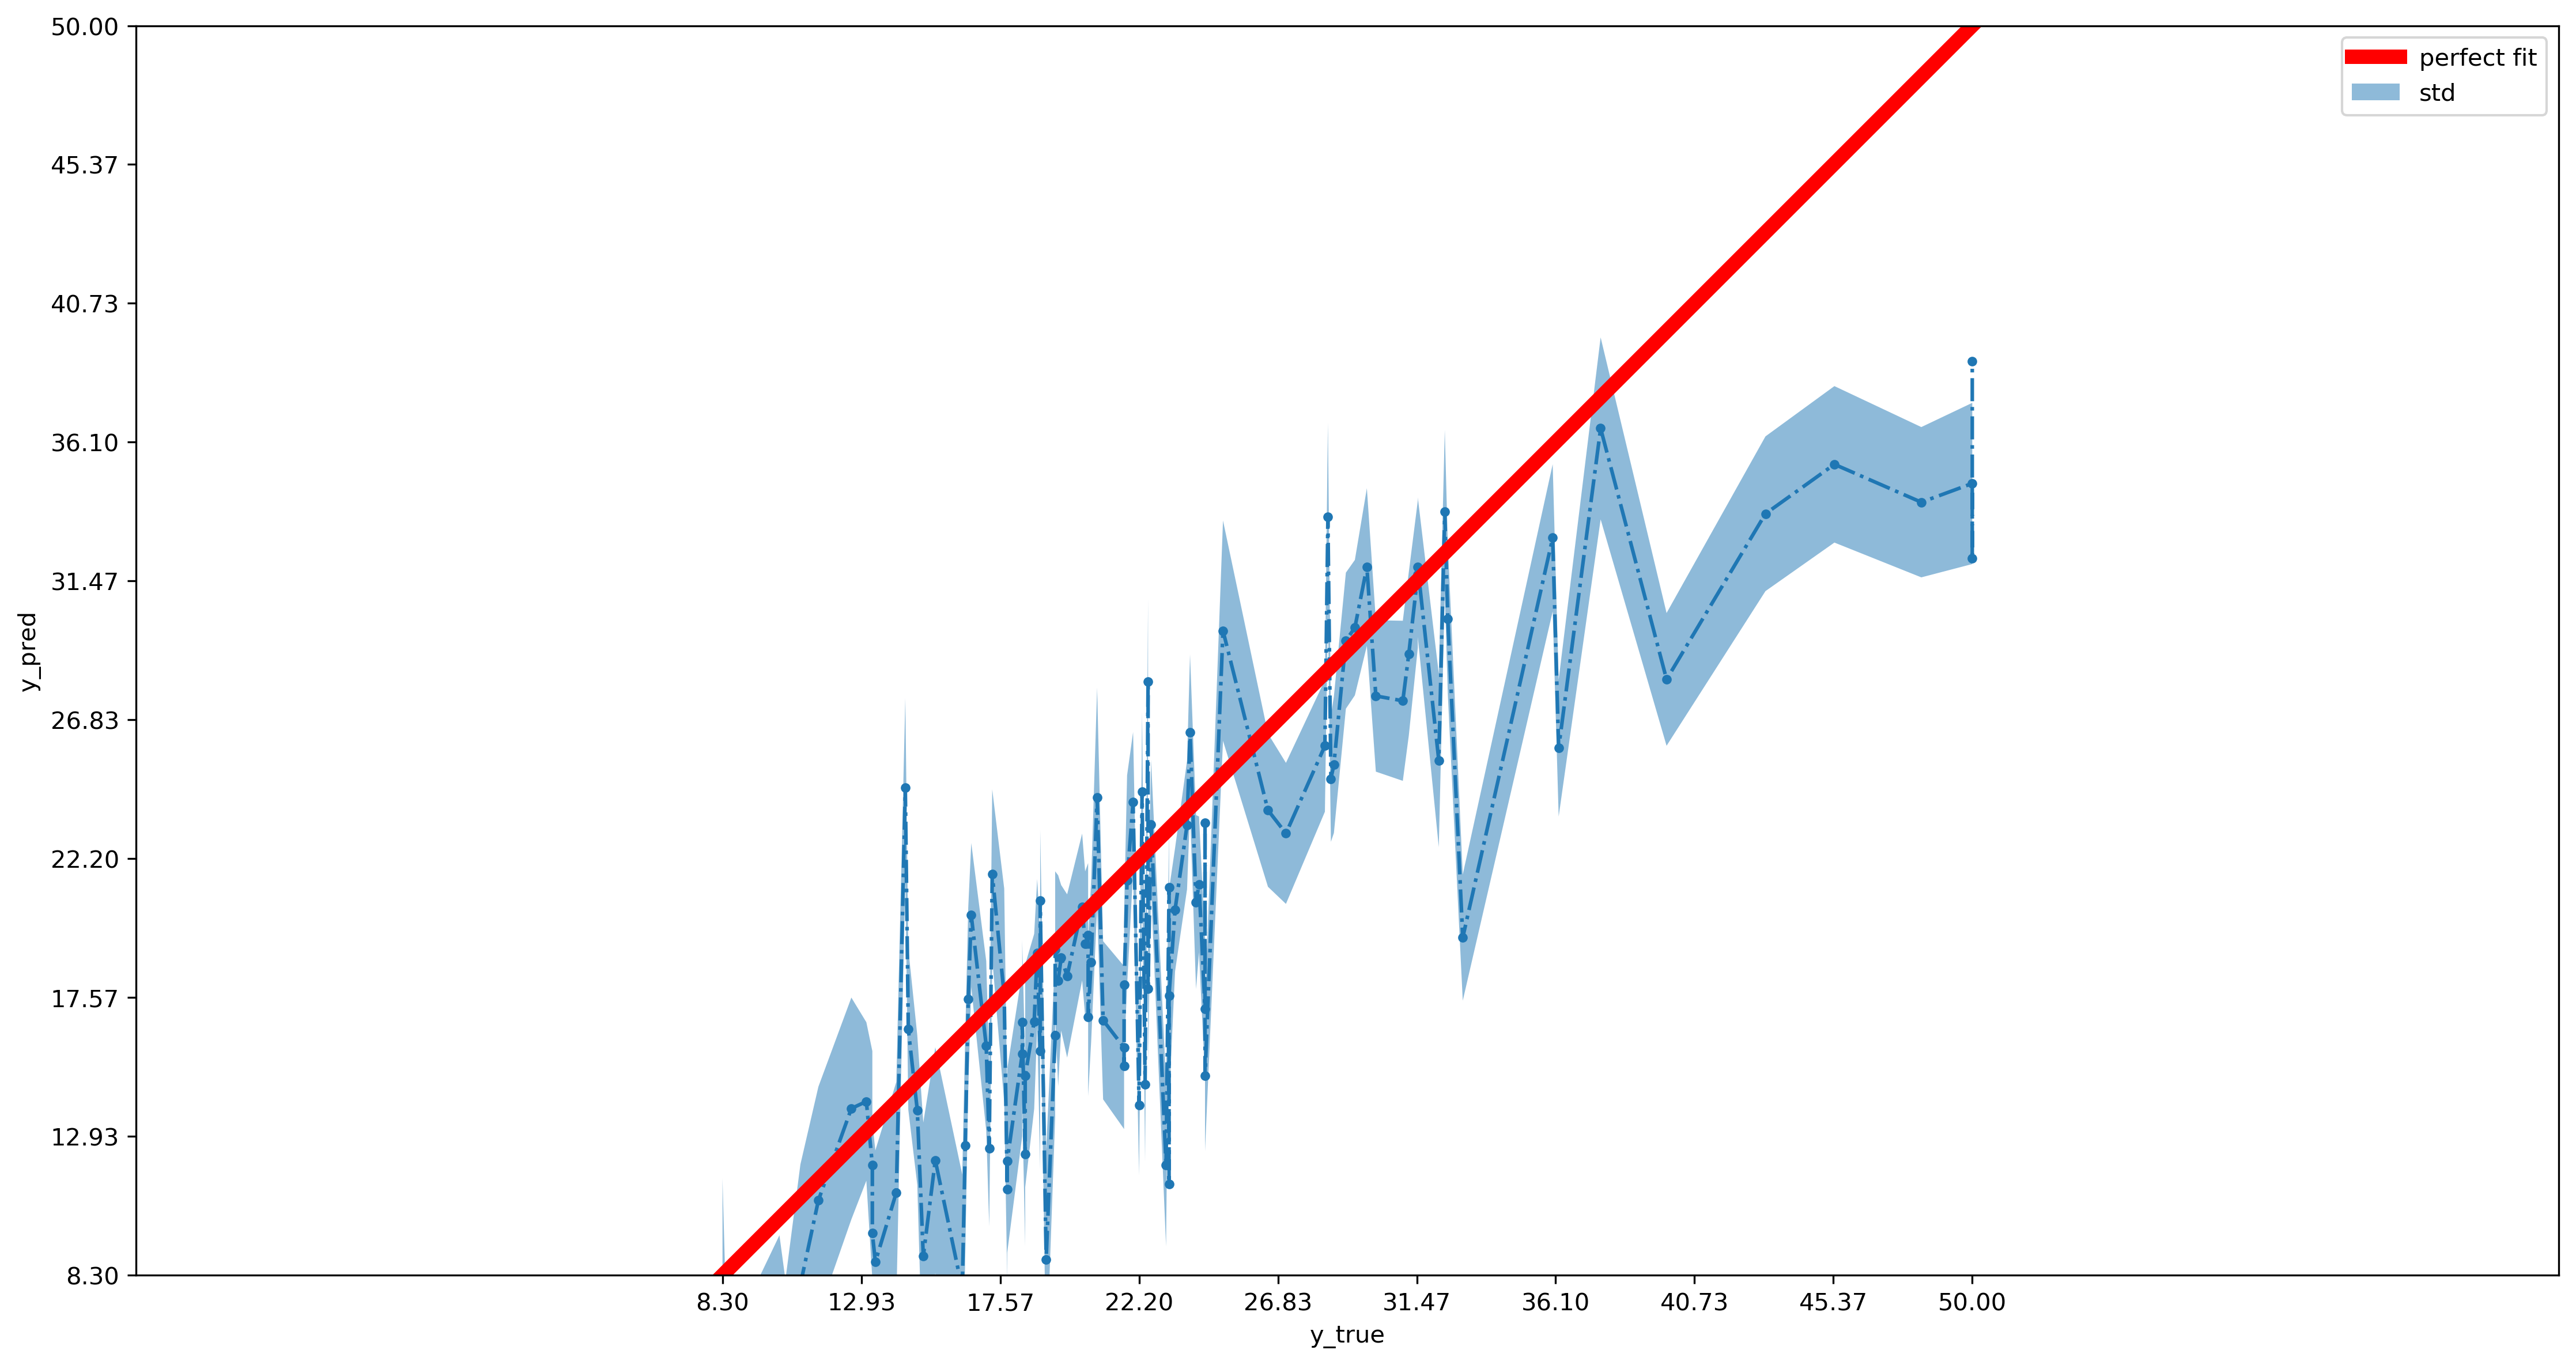

(array([[1.58603e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         7.68000e+00, 2.43900e+01],
        [1.36781e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         6.89500e+01, 3.40200e+01],
        [7.35341e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
         1.64500e+01, 2.06200e+01],
        ...,
        [5.26930e-01, 0.00000e+00, 6.20000e+00, ..., 1.74000e+01,
         3.82000e+02, 4.63000e+00],
        [5.60200e-02, 0.00000e+00, 2.46000e+00, ..., 1.78000e+01,
         3.92630e+02, 4.45000e+00],
        [1.50100e-02, 9.00000e+01, 1.21000e+00, ..., 1.36000e+01,
         3.95520e+02, 3.16000e+00]], dtype=float32),
 array([ 8.3,  8.4,  8.8, 10.2, 10.4, 10.9, 11.5, 12.6, 13.1, 13.3, 13.3,
        13.4, 14.1, 14.4, 14.5, 14.8, 15. , 15.4, 16.3, 16.4, 16.5, 16.6,
        17.1, 17.2, 17.3, 17.7, 17.8, 17.8, 18.3, 18.3, 18.4, 18.4, 18.7,
        18.8, 18.9, 18.9, 19.1, 19.4, 19.4, 19.4, 19.5, 19.6, 19.8, 20.3,
        20.4, 20.5, 20.5, 20.6, 20.8, 21. , 21.7, 21.7, 21.7, 

In [9]:
plot_pred_to_true(model, dataset)